# SI 618: Categorical Data



# Categorical Data

Categorical data are those that can take on one of a limited number of values (i.e. categories) (Wikipedia). Examples: blood type (A, B, AB, O); types of rock (sedimentary, metamorphic, igneous).

## Contingency tables, crosstabs, and chi-square

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline

Let's generate a data frame to play with:

In [2]:
df = pd.DataFrame({'color' : ['red', 'green', 'green', 'black'] * 6,
                   'make' : ['ford', 'toyota', 'dodge'] * 8,
                   'vehicleClass' : ['suv', 'suv', 'suv', 'car', 'car', 'truck'] * 4})

In [3]:
df

,color,make,vehicleClass
0,red,ford,suv
1,green,toyota,suv
2,green,dodge,suv
3,black,ford,car
4,red,toyota,car
5,green,dodge,truck
6,green,ford,suv
7,black,toyota,suv
8,red,dodge,suv
9,green,ford,car


One of the most basic transformations we can do is a crosstab:

In [4]:
ct = pd.crosstab(df.color,df.vehicleClass)
ct

vehicleClass,car,suv,truck
color,,,
black,2,2,2
green,4,6,2
red,2,4,0


Notice how similar it is to pivoting.  We can use ```pivot_table``` to create a DataFrame similar to the one from the ```crosstab``` above:

In [5]:
p = df.pivot_table(index='color',columns='vehicleClass',aggfunc=len)
p

make           
vehicleClass  car  suv truck
color                       
black         2.0  2.0   2.0
green         4.0  6.0   2.0
red           2.0  4.0   NaN

But that's not quite right; can you figure out how to make that pivot table **exactly** like the crosstab?

In [6]:
p = df.pivot_table(index='color',columns='vehicleClass',aggfunc=len,fill_value=0)
p

make          
vehicleClass  car suv truck
color                      
black           2   2     2
green           4   6     2
red             2   4     0

In [7]:
p.columns = p.columns.droplevel()
p

vehicleClass,car,suv,truck
color,,,
black,2,2,2
green,4,6,2
red,2,4,0


As usual, we would like to visualize our results:

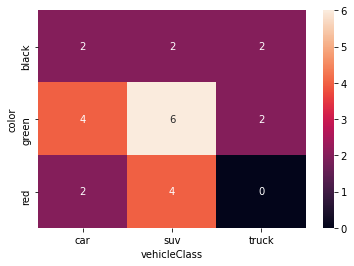

In [8]:
import seaborn as sns
sns.heatmap(ct,annot=True)

You might want to investigate other palettes, see https://seaborn.pydata.org/tutorial/color_palettes.html for more details.



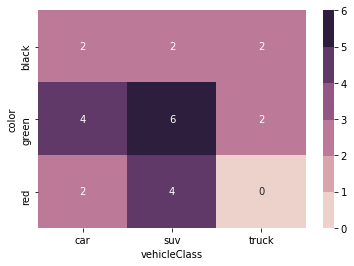

In [9]:
sns.heatmap(ct,annot=True,cmap=sns.cubehelix_palette())

### Titanic data

One of the more popular datasets that we use for experimenting with crosstabs is the 
survivor data from the Titanic disaster:

In [11]:
titanic = pd.read_csv('https://raw.githubusercontent.com/umsi-data-science/si370/master/data/titanic.csv')
titanic

,passtype,age,status,sex
0,third,child,dead,male
1,third,child,dead,male
2,third,child,dead,male
3,third,child,dead,male
4,third,child,dead,male
...,...,...,...,...
2196,crew,adult,alive,female
2197,crew,adult,alive,female
2198,crew,adult,alive,female
2199,crew,adult,alive,female


Let's create a crosstab of the data:

In [12]:
ct = pd.crosstab(titanic.passtype,titanic.status,margins=False)
ct

status,alive,dead
passtype,,
crew,212,673
first,203,122
second,118,167
third,178,528


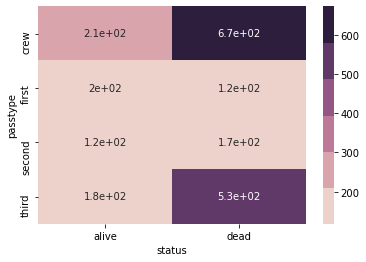

In [13]:
sns.heatmap(ct,annot=True,cmap=sns.cubehelix_palette())

Does scientific notation bother you?  Change the format with the ```fmt=``` argument:

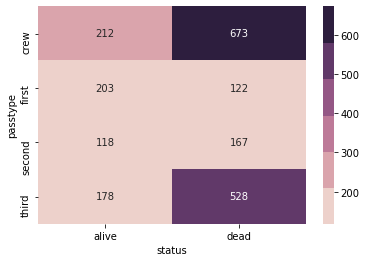

In [14]:
sns.heatmap(ct,annot=True,cmap=sns.cubehelix_palette(),fmt='d')

In addition to the heatmap shown above, we can use a mosaic plot to visualize 
contingency tables:

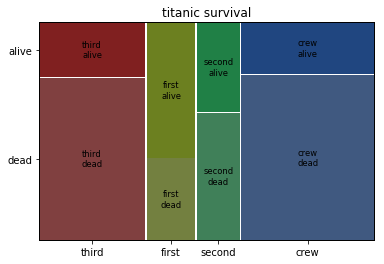

In [15]:
from statsmodels.graphics.mosaicplot import mosaic
t = mosaic(titanic, ['passtype','status'],title='titanic survival')

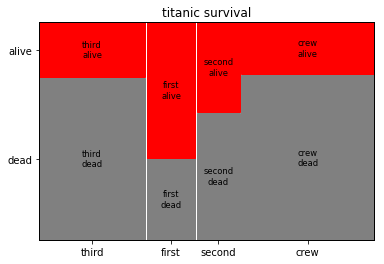

In [16]:
# slightly easier to read
props = lambda key: {'color': 'r' if 'alive' in key else 'gray'}
t = mosaic(titanic, ['passtype','status'],title='titanic survival',properties=props)

Let's take a look at the "expected" values for each cell.  That is,
the values that we would expect if there was no effect of "passtype" on "status".  To do this, let's take a look at the marginal totals:

In [17]:
ct = pd.crosstab(titanic.passtype,titanic.status,margins=True)
ct

status,alive,dead,All
passtype,,,
crew,212,673,885
first,203,122,325
second,118,167,285
third,178,528,706
All,711,1490,2201


The **expected** value for each cell (i.e. the value that you would expect if there was no interaction between passtype and status in this dataset) can be calculated by taking the row total multiplied by the column total and divided by the overall total.  

So we would get the following expected value for alive crew:

In [18]:
exp = ct['All'].loc['crew'] * ct['alive'].loc['All'] / ct['All'].loc['All']

In [19]:
exp

285.88596092685145

You could repeat this for each cell (or write code to do so), but you get the idea.

## Let's talk about $\chi^2$

Finally, we can go beyond visual exploration and apply analytic tests to see if the 
observed values differ from the expected ones.  The chi-square test sums the squares of the differences
between the observed and expected values, normalized for the expected values.

Our null hypothesis is that there is no difference in survivorship based on passage type.

Here's a video resource that explains chi-squared:

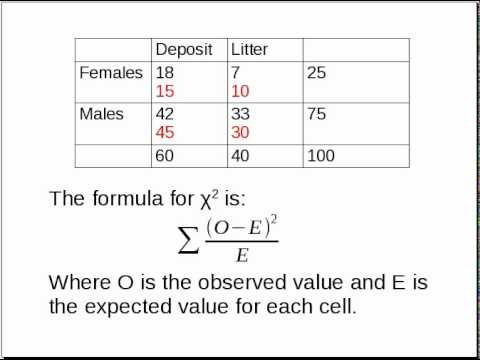

In [20]:
from IPython.display import YouTubeVideo
vid = YouTubeVideo("VskmMgXmkMQ")
display(vid)

In [21]:
from scipy.stats import chi2_contingency
chi2, p, dof, ex = chi2_contingency(ct)
print("chi2 = ", chi2)
print("p-val = ", p)
print("degree of freedom = ",dof)

chi2 =  190.40110361683327
p-val =  6.705773035354302e-37
degree of freedom =  8


As a bonus, we also get a DataFrame of the expected values:

In [22]:
pd.DataFrame(ex)

,0,1,2
0,285.885961,599.114039,885.0
1,104.986370,220.013630,325.0
2,92.064970,192.935030,285.0
3,228.062699,477.937301,706.0
4,711.000000,1490.000000,2201.0
